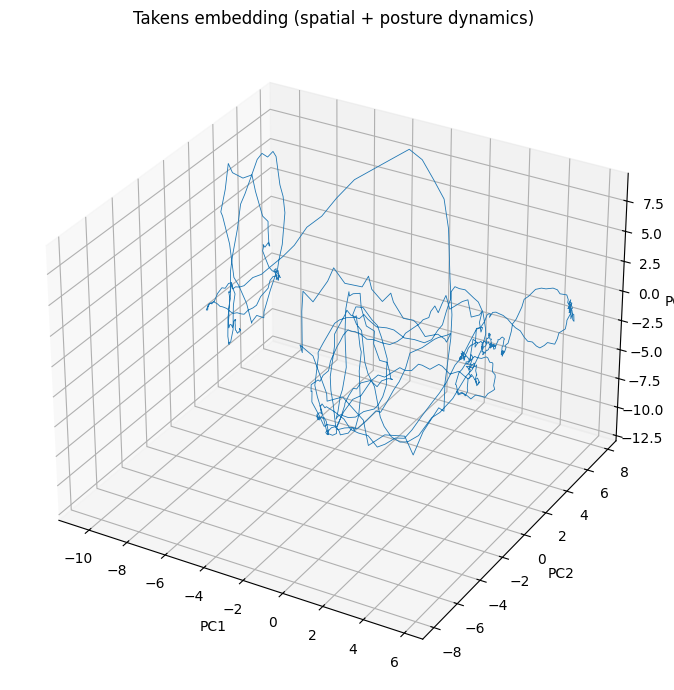

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter


# =========================
# Takens embedding
# =========================
def takens_embedding(X, delay=3, dimension=8):
    """
    X: (T, D) time series
    Returns: (T - (m-1)*delay, D*m)
    """
    T, D = X.shape
    max_shift = (dimension - 1) * delay
    if T <= max_shift:
        raise ValueError("Time series too short for chosen delay/dimension")

    return np.hstack([
        X[i * delay : T - max_shift + i * delay]
        for i in range(dimension)
    ])


# =========================
# Load CSV
# =========================
dat = pd.read_csv(
    "/home/maria/MouseBox/selected_data/models/gpu_working/video_preds/session_view.csv"
)

# Metadata rows
bodyparts = dat.iloc[0, 1:].values
coords    = dat.iloc[1, 1:].values
columns = [f"{bp}_{c}" for bp, c in zip(bodyparts, coords)]

# Numeric pose data
X = dat.iloc[2:, 1:].astype(float)
X.columns = columns
X.reset_index(drop=True, inplace=True)

# Keep only x,y columns
xy_cols = [c for c in X.columns if c.endswith("_x") or c.endswith("_y")]
X_xy = X[xy_cols].values  # (T, 6)


# =========================
# Reshape: (T, keypoints=3, xy=2)
# =========================
X_xy = X_xy.reshape(-1, 3, 2)

# -------------------------
# NO CENTERING
# -------------------------
X_uncentered = X_xy.reshape(len(X_xy), -1)  # (T, 6)


# =========================
# Smooth positions (important!)
# =========================
X_smooth = savgol_filter(
    X_uncentered,
    window_length=11,  # try 7–15
    polyorder=2,
    axis=0
)


# =========================
# Velocities
# =========================
V = np.diff(X_smooth, axis=0, prepend=X_smooth[[0]])

# Final per-frame feature
X_feat = np.concatenate([X_smooth, V], axis=1)  # (T, 12)


# =========================
# Takens embedding
# =========================
tau = 3    # delay (frames)
m   = 8    # embedding dimension

X_takens = takens_embedding(X_feat, delay=tau, dimension=m)


# =========================
# Normalize
# =========================
X_takens = StandardScaler().fit_transform(X_takens)


# =========================
# PCA → 3D
# =========================
Z = PCA(n_components=3).fit_transform(X_takens)


# =========================
# Plot trajectory
# =========================
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")

ax.plot(Z[:, 0], Z[:, 1], Z[:, 2], lw=0.6)

ax.set_title("Takens embedding (spatial + posture dynamics)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.tight_layout()
plt.show()


In [4]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 18.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 21.3 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter

import plotly.graph_objects as go


# =========================
# Takens embedding
# =========================
def takens_embedding(X, delay=3, dimension=8):
    T, D = X.shape
    max_shift = (dimension - 1) * delay
    if T <= max_shift:
        raise ValueError("Time series too short for chosen delay/dimension")

    return np.hstack([
        X[i * delay : T - max_shift + i * delay]
        for i in range(dimension)
    ])


# =========================
# Load CSV
# =========================
dat = pd.read_csv(
    "/home/maria/MouseBox/selected_data/models/gpu_working/video_preds/session_view.csv"
)

bodyparts = dat.iloc[0, 1:].values
coords    = dat.iloc[1, 1:].values
columns = [f"{bp}_{c}" for bp, c in zip(bodyparts, coords)]

X = dat.iloc[2:, 1:].astype(float)
X.columns = columns
X.reset_index(drop=True, inplace=True)

xy_cols = [c for c in X.columns if c.endswith("_x") or c.endswith("_y")]
X_xy = X[xy_cols].values


# =========================
# Reshape (T, 3, 2)
# =========================
X_xy = X_xy.reshape(-1, 3, 2)

# -------------------------
# NO CENTERING (keep space)
# -------------------------
X_uncentered = X_xy.reshape(len(X_xy), -1)  # (T, 6)


# =========================
# Smooth
# =========================
X_smooth = savgol_filter(
    X_uncentered,
    window_length=11,
    polyorder=2,
    axis=0
)


# =========================
# Velocity
# =========================
V = np.diff(X_smooth, axis=0, prepend=X_smooth[[0]])
X_feat = np.concatenate([X_smooth, V], axis=1)


# =========================
# Takens
# =========================
tau = 3
m   = 8

X_takens = takens_embedding(X_feat, delay=tau, dimension=m)


# =========================
# Normalize + PCA
# =========================
X_takens = StandardScaler().fit_transform(X_takens)
Z = PCA(n_components=3).fit_transform(X_takens)


# =========================
# Plotly 3D trajectory
# =========================
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=Z[:, 0],
            y=Z[:, 1],
            z=Z[:, 2],
            mode="lines",
            line=dict(width=3),
        )
    ]
)

fig.update_layout(
    title="Takens embedding (spatial + posture dynamics)",
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3",
        aspectmode="data",
    ),
    margin=dict(l=0, r=0, b=0, t=40),
)

fig.show()


In [7]:
!pip install nbformat

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 10.7 MB/s eta 0:00:0000:01


In [2]:
!pip install dash plotly opencv-python scikit-learn scipy pandas


  Using cached zipp-3.23.0-py3-none-any.whl.metadata (3.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 15.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 14.6 MB/s eta 0:00:00
Using cached zipp-3.23.0-py3-none-any.whl (10 kB)
